In [1]:
from os.path import join
import sys
if '../code_revised' not in sys.path:
    sys.path.insert(0, '../code_revised')

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tf
from flyeye.data import Experiment
from figures.images import RatioImage
from figures.spatial import Correlation, Periodogram, R8Spacing

data_path = '../data/published/'

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [648]:
import cv2
from copy import deepcopy
from matplotlib.path import Path
from matplotlib.collections import PathCollection
from flyqma.data.silhouette_read import ReadSilhouetteData

p = '../data/published/wildtype/eye2.silhouette'

silhouette = ReadSilhouetteData(p, recompile=True)
data = silhouette.read_contours(include_unlabeled=True)
data = data.drop('label', axis=1, inplace=False)
data = data.set_index(['layer', 'segment_id']).join(silhouette.labels)
image = deepcopy(cv2.imread(join(silhouette.path, '{:d}.png'.format(layer)))[:,:,::-1])

In [649]:
layer = 25
layer_data = data.loc[layer]
labeled = layer_data[~layer_data.label.isna()]

print(labeled.label.unique())

['r8' 'r2' 'r5' 'r7' 'r6' 'r4' 'c3' 'c1' 'r3']


# Segmentation image

In [455]:
# get His-RFP image
im_segmentation = deepcopy(image)
im_segmentation[:,:,1] = im_segmentation[:,:,0]
im_segmentation[:,:,2] = im_segmentation[:,:,0]

# draft contours on layer image
contours = [np.array(x) for x in data.loc[layer].segment]
_ = cv2.drawContours(im_segmentation, contours, -1, [255,255,0], thickness=1)

tf.imwrite('segmentation.tif', data=im_segmentation)

# Stain image

In [456]:
# get His-RFP image
im_stain = deepcopy(image)

tf.imwrite('stain.tif', data=im_stain)

# Labels image

In [457]:
# get His-RFP image
im_labeling = deepcopy(image)
im_labeling[:,:,1] = im_labeling[:,:,0]
im_labeling[:,:,2] = im_labeling[:,:,0]

# draft contours on layer image
contours = [np.array(x) for x in data.loc[layer].segment]
_ = cv2.drawContours(im_labeling, contours, -1, [255,255,0], thickness=1)

# add labels
shift = np.array([10, -5])
for idx, record in labeled.iterrows():
    pos = record[['centroid_x', 'centroid_y']].values - shift
    label = record.label
    cv2.putText(im_labeling, label.upper(), tuple(pos.astype(int)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=(255,255,255), thickness=1)    
    
tf.imwrite('labeling.tif', data=im_labeling)

# Pnt image

In [651]:
# get His-RFP image
im = deepcopy(image)
im[:,:,0] = 0
im[:,:,1] = 0
#im[:,:,2] = 0

# draft contours on layer image
contours = [np.array(x) for x in data.loc[layer].segment]
_ = cv2.drawContours(im, contours, -1, [255,255,0], thickness=1)

# # add labels
# shift = np.array([10, -5])
# for idx, record in labeled.iterrows():
#     pos = record[['centroid_x', 'centroid_y']].values - shift
#     label = record.label
#     cv2.putText(im, label.upper(), tuple(pos.astype(int)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=(255,255,255), thickness=1)    
    
tf.imwrite('yan.tif', data=im)

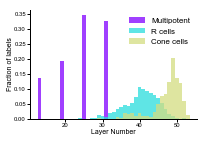

In [576]:
progenitors = ['pre']
neurons = ['r8', 'r2', 'r5', 'r1', 'r6', 'r7']
cones = ['c1', 'c2', 'c3', 'c4']
labels = ('Multipotent', 'R cells', 'Cone cells')

num_layers = max(silhouette.feed['layer_ids'])
fig, ax = plt.subplots(figsize=(3, 2))
for i, celltypes in enumerate([progenitors, neurons, cones]):    
    cells = data[data.label.isin(celltypes)]
    hist = cells.groupby('layer')['label'].count()
    color = plt.cm.rainbow(i/3)
    ax.bar(num_layers-hist.index.values, hist.values/len(cells), color=color, width=1., label=labels[i], alpha=0.75)
    
ax.set_ylabel('Fraction of labels')
ax.set_xlabel('Layer Number')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc=0, frameon=False, fontsize=8)

fig.savefig('layer_distribution.png', transparent=False, dpi=300)

In [584]:
data[data.label.isin(neurons)].groupby('layer')['label'].count()

layer
7      1
9      3
10     8
11    14
12    30
13    47
14    61
15    71
16    77
17    83
18    90
19    95
20    64
21    47
22    37
23    42
24    36
25    28
26    21
27    18
28     4
29     9
30    10
31     2
32     1
35     1
Name: label, dtype: int64

In [ ]:
"""
Disc 2, Layers 12-27 contain R cells
"""

In [647]:
59-16

43

In [596]:
def max_projection(silhouette, layer_range=(12,28)):
    layers = []
    for layer_id in range(*layer_range):
        layer_image = deepcopy(cv2.imread(join(silhouette.path, '{:d}.png'.format(layer_id)))[:,:,::-1])
        layers.append(layer_image)
    return np.stack(layers).max(axis=0)    

In [643]:
layer_range = (12, 16)
stack = max_projection(silhouette, layer_range=layer_range)
labels = data[data.label.isin(neurons)].loc[range(*layer_range)]

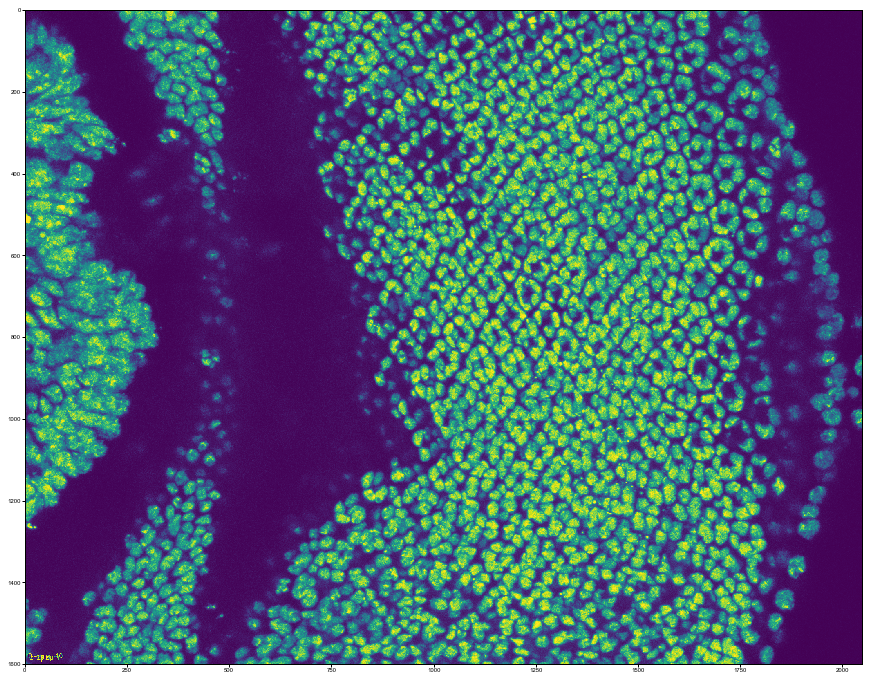

In [644]:
fig,ax=plt.subplots(figsize=(15,15))
ax.imshow(stack[:,:,0])

In [645]:
# get His-RFP image
im = deepcopy(stack)
im[:,:,1] = 0#im[:,:,0]
im[:,:,2] = 0#im[:,:,0]

# add labels
shift = np.array([10, -5])
for idx, record in labels.iterrows():
    pos = record[['centroid_x', 'centroid_y']].values - shift
    label = record.label
    cv2.putText(im, label.upper(), tuple(pos.astype(int)), cv2.FONT_HERSHEY_DUPLEX, 0.5, color=(255,255,255), thickness=1)    
    
tf.imwrite('projection_labeled.tif', data=im)